# readme


# package

In [13]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# data examine

In [14]:
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

train_df.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


# model training

In [15]:


# ==========================================
# 1. 模擬產生資料 (你可以替換成讀取你的 train_df)
# ==========================================
def generate_mock_data(n_rows=1000):
    data = {
        'id': range(1, n_rows + 1),
        'age': np.random.randint(20, 70, size=n_rows),      # 離散數值
        'salary': np.random.uniform(30000, 100000, n_rows), # 連續數值
        'is_member': np.random.choice([True, False], n_rows), # Boolean
        'city': np.random.choice(['Taipei', 'Kaohsiung', 'Taichung', None], n_rows), # Category (含缺值)
        'label': np.random.choice([0, 1], n_rows) # Target
    }
    return pd.DataFrame(data)

def bool_to_int_helper(x):
    """將布林值轉換為整數 (0/1) 的輔助函數"""
    return x.astype(int)

def build_pipeline(X_train):
    
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    bool_features = X_train.select_dtypes(include=['bool']).columns.tolist()

    print(f"--- Feature Types Detected ---")
    print(f"Numeric: {numeric_features}")
    print(f"Categorical: {categorical_features}")
    print(f"Boolean: {bool_features}")

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), 
        ('scaler', StandardScaler()) 
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
    ])

    # [FIX] 這裡改用定義好的 Global Function，而不是 lambda
    bool_transformer = Pipeline(steps=[
        ('to_int', FunctionTransformer(bool_to_int_helper, validate=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('bool', bool_transformer, bool_features)
        ],
        verbose_feature_names_out=False
    )

    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(
            n_estimators=100, 
            learning_rate=0.05, 
            use_label_encoder=False, 
            eval_metric='logloss',
            random_state=42
        ))
    ])

    return model_pipeline

# ==========================================
# 3. 訓練與儲存流程
# ==========================================
def train_and_save(df, model_path='../model/xgb_model_pipeline.pkl'):
    print("\n--- Starting Training Process ---")
    
    # 分離 ID, Feature, Label
    # 假設第一個是 ID，最後一個是 Label
    target_col = df.columns[-1]
    id_col = df.columns[0]
    
    X = df.drop(columns=[id_col, target_col])
    y = df[target_col]

    # 切分訓練與驗證集
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # 建立 Pipeline
    pipeline = build_pipeline(X_train)

    # 訓練模型
    print("Training XGBoost...")
    pipeline.fit(X_train, y_train)

    # 驗證模型
    y_pred = pipeline.predict(X_val)
    print("\nValidation Results:")
    print(classification_report(y_val, y_pred))

    # 儲存整個 Pipeline (包含預處理邏輯與模型)
    joblib.dump(pipeline, model_path)
    print(f"Model saved to {model_path}")
    
    return pipeline

# ==========================================
# 4. 推論函數 (Inference Function)
# ==========================================
def predict_data(new_df, model_path='../model/xgb_model_pipeline.pkl'):
    """
    讀取新資料 (含有 ID)，載入模型，並輸出結果
    """
    print(f"\n--- Loading model from {model_path} ---")
    pipeline = joblib.load(model_path)
    
    # 處理 ID (需先取出，最後再合併回去)
    id_col = new_df.columns[0]
    ids = new_df[id_col]
    
    # 確保輸入給模型的欄位不包含 ID 和 Label (如果有的話)
    # 這裡假設推論資料沒有 Label，只有 ID 和 Features
    X_new = new_df.drop(columns=[id_col])
    
    # 直接預測 (Pipeline 會自動處理缺失值、類別轉換)
    try:
        probs = pipeline.predict_proba(X_new)[:,1]
        # 如果需要機率值:
        # probs = pipeline.predict_proba(X_new)[:, 1]
    except ValueError as e:
        print(f"Error during prediction: {e}")
        return None

    # 整理結果
    result_df = pd.DataFrame({
        id_col: ids,
        'probability': probs
    })
    
    return result_df


In [16]:

# ==========================================
# 5. 主程式執行範例
# ==========================================

#train_df = pd.read_csv("/kaggle/input/playground-series-s5e12/train.csv")
train_df = pd.read_csv("../data/train.csv")
print("Raw Data Sample:")
print(train_df.head())

# 2. 訓練並儲存
train_and_save(train_df, '../model/my_xgboost.pkl')

# 3. 模擬推論 (產生新的測試資料)
test_df = pd.read_csv("../data/test.csv")

# # 故意加入一些訓練時沒看過的類別或缺值測試魯棒性
# test_df.loc[0, 'city'] = 'New York' # 新類別
# test_df.loc[1, 'salary'] = np.nan   # 缺值

# 4. 執行推論
results = predict_data(test_df, '../model/my_xgboost.pkl')

print("\nInference Results:")
print(results)

Raw Data Sample:
   id  age  alcohol_consumption_per_week  physical_activity_minutes_per_week  \
0   0   31                             1                                  45   
1   1   50                             2                                  73   
2   2   32                             3                                 158   
3   3   54                             3                                  77   
4   4   54                             1                                  55   

   diet_score  sleep_hours_per_day  screen_time_hours_per_day   bmi  \
0         7.7                  6.8                        6.1  33.4   
1         5.7                  6.5                        5.8  23.8   
2         8.5                  7.4                        9.1  24.1   
3         4.6                  7.0                        9.2  26.6   
4         5.7                  6.2                        5.1  28.8   

   waist_to_hip_ratio  systolic_bp  ...  gender  ethnicity  education_level

d:\miniconda3\envs\diabete\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:32:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Validation Results:
              precision    recall  f1-score   support

         0.0       0.61      0.35      0.45     52629
         1.0       0.69      0.87      0.77     87371

    accuracy                           0.67    140000
   macro avg       0.65      0.61      0.61    140000
weighted avg       0.66      0.67      0.65    140000

Model saved to ../model/my_xgboost.pkl

--- Loading model from ../model/my_xgboost.pkl ---

Inference Results:
            id  probability
0       700000     0.529878
1       700001     0.617295
2       700002     0.707029
3       700003     0.528135
4       700004     0.830629
...        ...          ...
299995  999995     0.686911
299996  999996     0.680791
299997  999997     0.475302
299998  999998     0.616829
299999  999999     0.593767

[300000 rows x 2 columns]


In [17]:
results.to_csv('../data/submission.csv', index=False)

# adjust feature selection

In [18]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# ==========================================
# 1. Helper Function (必須保留以解決 pickle 問題)
# ==========================================
def bool_to_int_helper(x):
    """將布林值轉換為整數 (0/1)"""
    return x.astype(int)

# ==========================================
# 2. [Modified] 僅針對數值型與布林型建立 Pipeline
# ==========================================
def build_numerical_pipeline(X_train):
    """
    只處理數值 (int/float) 和布林 (bool) 特徵，忽略類別特徵
    """
    
    # 1. 偵測欄位：只選取數值和布林
    # include='number' 會包含 int64, float64 等
    numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
    bool_features = X_train.select_dtypes(include=['bool']).columns.tolist()
    
    # 為了確認，印出被選用的特徵
    print(f"--- Numerical Model Features ---")
    print(f"Numeric Used: {numeric_features}")
    print(f"Boolean Used: {bool_features}")
    print(f"(Categorical features will be dropped)")

    # 2. 定義處理邏輯
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), 
        ('scaler', StandardScaler()) 
    ])

    bool_transformer = Pipeline(steps=[
        ('to_int', FunctionTransformer(bool_to_int_helper, validate=False))
    ])

    # 3. 組合 ColumnTransformer
    # remainder='drop' 是預設值，代表沒列在這裡的欄位(即類別欄位)會被丟掉
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('bool', bool_transformer, bool_features)
        ],
        remainder='drop', 
        verbose_feature_names_out=False
    )

    # 4. 建立模型 Pipeline
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(
            n_estimators=100, 
            learning_rate=0.05, 
            use_label_encoder=False, 
            eval_metric='logloss',
            random_state=42
        ))
    ])

    return model_pipeline

# ==========================================
# 3. 訓練與儲存流程 (含 AUC 與 Probability)
# ==========================================
def train_and_save(df, model_path='xgb_numeric_only.pkl'):
    print("\n--- Starting Training (Numerical Only) ---")
    
    # 分離 ID 與 Label
    target_col = df.columns[-1]
    id_col = df.columns[0]
    
    X = df.drop(columns=[id_col, target_col])
    y = df[target_col]

    # 切分資料
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # [Modified] 呼叫新的 Pipeline 建構函數
    pipeline = build_numerical_pipeline(X_train)

    print("Training XGBoost...")
    pipeline.fit(X_train, y_train)

    # 驗證
    y_pred = pipeline.predict(X_val)
    y_prob = pipeline.predict_proba(X_val)[:, 1] # 取得機率

    print("\nValidation Results:")
    print(classification_report(y_val, y_pred))
    
    auc = roc_auc_score(y_val, y_prob)
    print(f"ROC-AUC Score: {auc:.4f}")

    joblib.dump(pipeline, model_path)
    print(f"Model saved to {model_path}")
    
    return pipeline

# ==========================================
# 4. 推論函數 (輸出機率)
# ==========================================
def predict_data(new_df, model_path='xgb_numeric_only.pkl'):
    print(f"\n--- Loading model from {model_path} ---")
    pipeline = joblib.load(model_path)
    
    id_col = new_df.columns[0]
    ids = new_df[id_col]
    X_new = new_df.drop(columns=[id_col])
    
    try:
        # 輸出機率 (Label=1 的機率)
        probs = pipeline.predict_proba(X_new)[:, 1]
    except ValueError as e:
        print(f"Error during prediction: {e}")
        return None

    result_df = pd.DataFrame({
        id_col: ids,
        'probability': probs
    })
    
    return result_df

# ==========================================
# 5. 模擬資料生成 (保持不變)
# ==========================================
def generate_mock_data(n_rows=1000):
    data = {
        'id': range(1, n_rows + 1),
        'age': np.random.randint(20, 70, size=n_rows),       # 數值 (會被保留)
        'salary': np.random.uniform(30000, 100000, n_rows),  # 數值 (會被保留)
        'is_member': np.random.choice([True, False], n_rows),# Boolean (會被保留)
        'city': np.random.choice(['Taipei', 'Kaohsiung', 'Taichung', None], n_rows), # 類別 (會被丟棄)
        'label': np.random.choice([0, 1], n_rows) 
    }
    return pd.DataFrame(data)


In [19]:

# ==========================================
# 主程式
# ==========================================
#if __name__ == "__main__":
# 1. 準備資料
#train_df = generate_mock_data(1000)
#print("Raw data columns:", train_df.columns.tolist())
train_df = pd.read_csv('../data/train.csv')
# 2. 訓練並儲存 (只會用 age, salary, is_member)
train_and_save(train_df, '../model/xgb_numeric_only.pkl')

# 3. 模擬推論
#test_df = generate_mock_data(10).drop(columns=['label']) 
test_df = pd.read_csv('../data/test.csv')
# 4. 執行推論
results = predict_data(test_df, '../model/xgb_numeric_only.pkl')

print("\nInference Results (Probability):")
print(results.head())
results.to_csv('../data/submission_numeric.csv',index=False)


--- Starting Training (Numerical Only) ---
--- Numerical Model Features ---
Numeric Used: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']
Boolean Used: []
(Categorical features will be dropped)
Training XGBoost...


d:\miniconda3\envs\diabete\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:32:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Validation Results:
              precision    recall  f1-score   support

         0.0       0.61      0.35      0.45     52629
         1.0       0.69      0.87      0.77     87371

    accuracy                           0.67    140000
   macro avg       0.65      0.61      0.61    140000
weighted avg       0.66      0.67      0.65    140000

ROC-AUC Score: 0.7119
Model saved to ../model/xgb_numeric_only.pkl

--- Loading model from ../model/xgb_numeric_only.pkl ---

Inference Results (Probability):
       id  probability
0  700000     0.533418
1  700001     0.605718
2  700002     0.706869
3  700003     0.523757
4  700004     0.848117


# feature visualization


--- Generating Feature Visualizations ---


KeyboardInterrupt: 

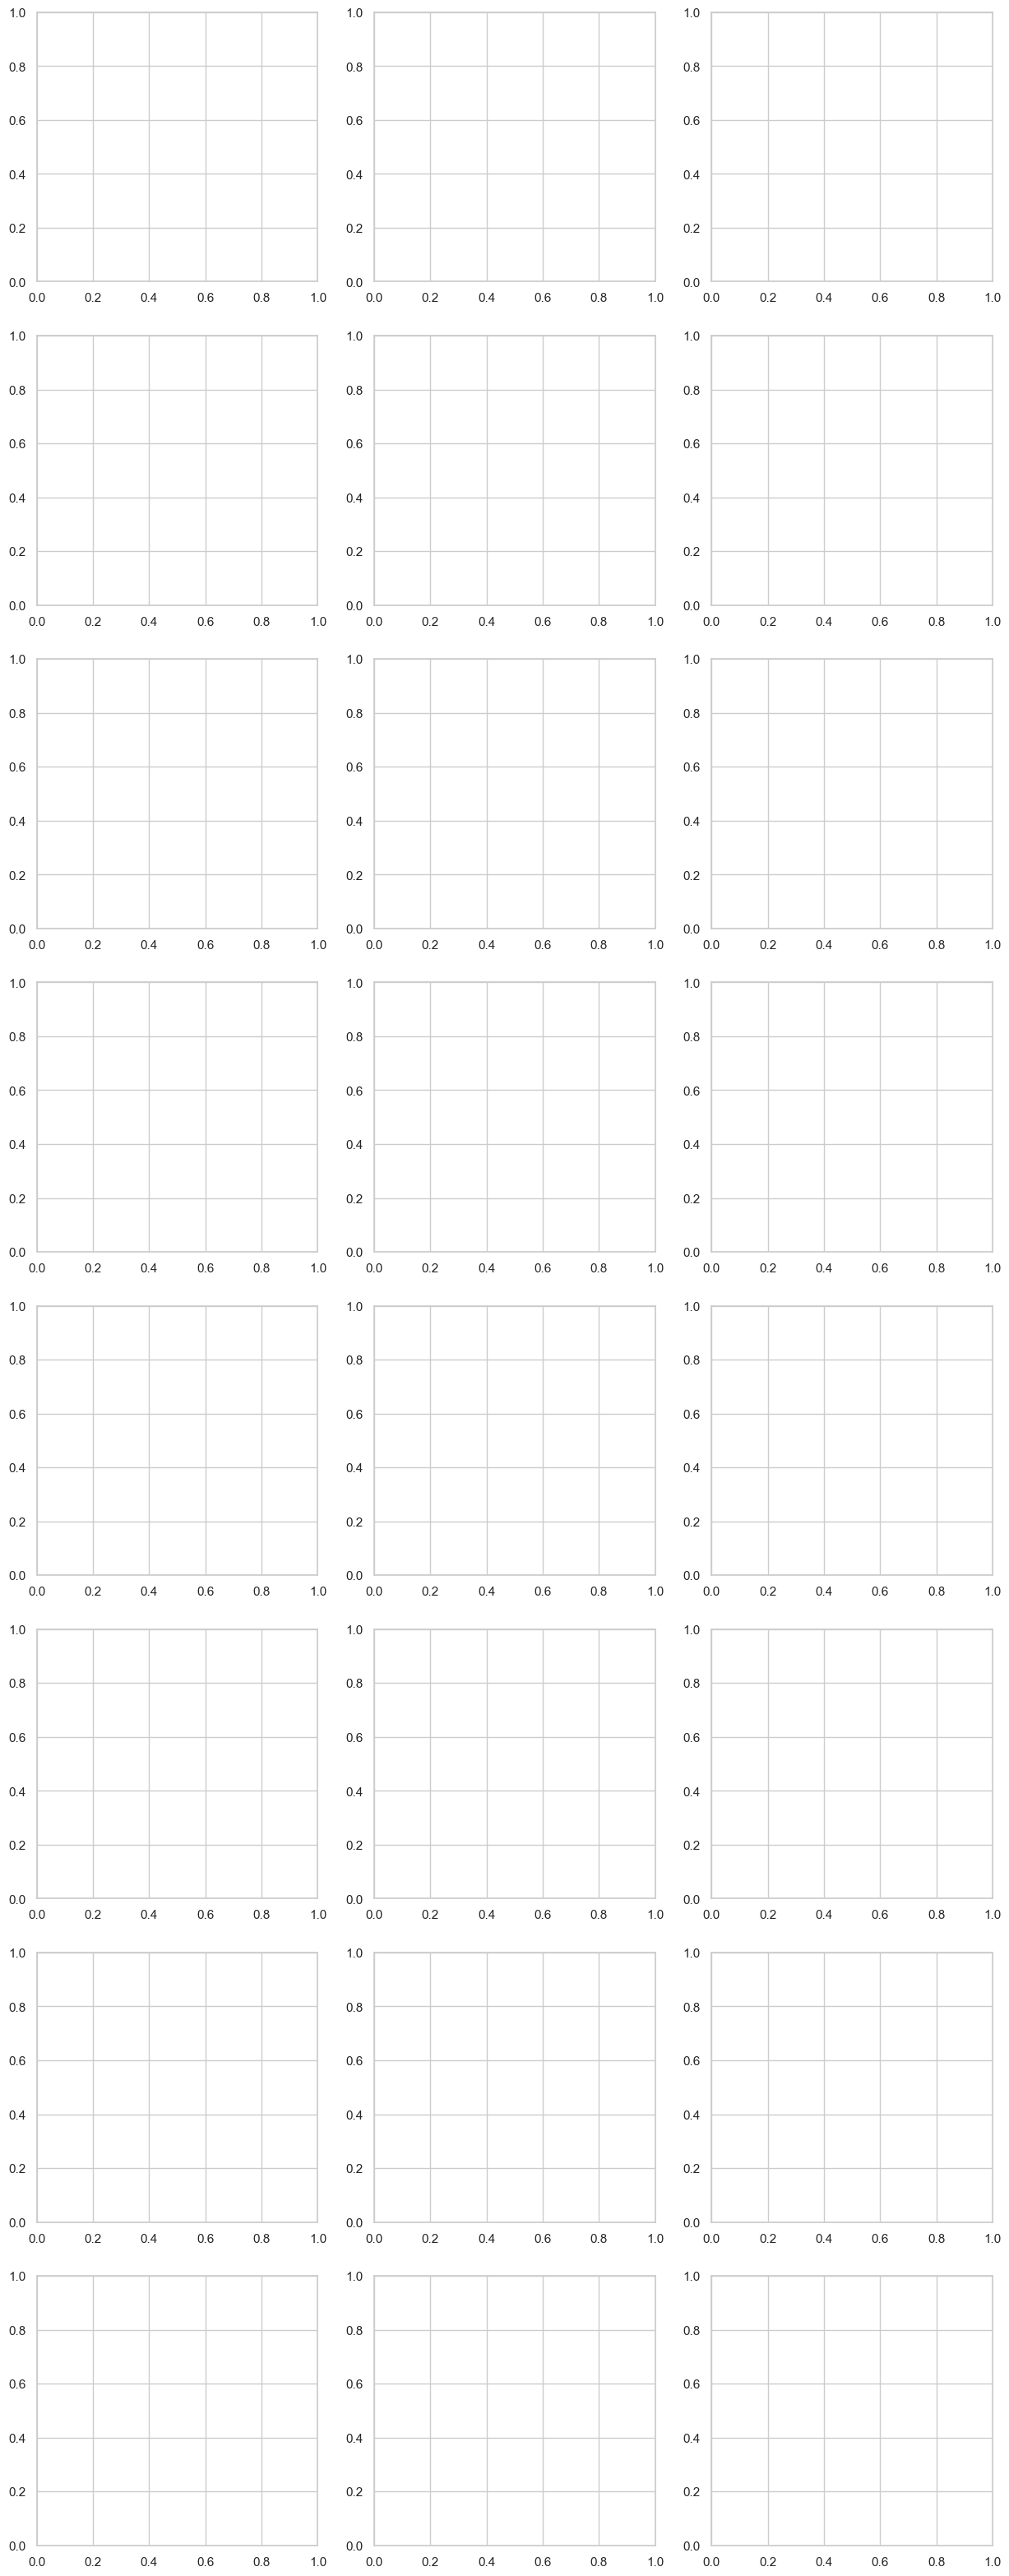

In [20]:
import seaborn as sns  # [新增] 用於繪圖
import math
import matplotlib.pyplot as plt
def visualize_feature_distributions(df):
    """
    自動針對 train_df 的特徵進行視覺化，並依據 label 區分顏色
    """
    print("\n--- Generating Feature Visualizations ---")
    
    # 設定繪圖風格
    sns.set(style="whitegrid")
    
    # 辨識欄位
    id_col = df.columns[0]
    target_col = df.columns[-1]
    feature_cols = df.columns[1:-1]
    
    # 分離數值與類別欄位
    numeric_cols = df[feature_cols].select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df[feature_cols].select_dtypes(include=['object', 'category', 'bool']).columns
    
    total_plots = len(numeric_cols) + len(categorical_cols)
    cols_per_row = 3
    rows = math.ceil(total_plots / cols_per_row)
    
    # 設定畫布大小
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 5 * rows))
    axes = axes.flatten() # 攤平方便迭代
    
    # 1. 繪製數值型特徵 (Histogram + KDE)
    for i, col in enumerate(numeric_cols):
        sns.histplot(
            data=df, x=col, hue=target_col, 
            kde=True, element="step", stat="density", common_norm=False,
            ax=axes[i], palette="viridis"
        )
        axes[i].set_title(f"Distribution of {col} by Label")
    
    # 2. 繪製類別/布林型特徵 (Countplot)
    for j, col in enumerate(categorical_cols):
        # 接續 numeric 的 index
        ax_idx = len(numeric_cols) + j
        
        # 如果類別太多 (例如超過 10 個)，只取前 10 大，避免圖表擁擠
        if df[col].nunique() > 10:
            top_n = df[col].value_counts().index[:10]
            data_to_plot = df[df[col].isin(top_n)]
            title_suffix = "(Top 10 Categories)"
        else:
            data_to_plot = df
            title_suffix = ""
            
        sns.countplot(
            data=data_to_plot, x=col, hue=target_col, 
            ax=axes[ax_idx], palette="viridis"
        )
        axes[ax_idx].set_title(f"Count of {col} by Label {title_suffix}")
        
        # 如果標籤字太長，旋轉一下
        axes[ax_idx].tick_params(axis='x', rotation=45)

    # 隱藏多餘的空白子圖
    for k in range(total_plots, len(axes)):
        fig.delaxes(axes[k])
        
    plt.tight_layout()
    plt.show()
    print("--- Visualization Complete ---\n")

visualize_feature_distributions(train_df)

# SHAP

In [ ]:
import shap
import matplotlib.pyplot as plt

def explain_model_with_shap(df, model_path='xgb_model_pipeline.pkl'):
    """
    使用 SHAP 解釋模型：
    1. 處理 Pipeline 資料轉換
    2. 還原 Feature Name
    3. 繪製 Summary Plot
    """
    print(f"\n--- Starting SHAP Analysis using model: {model_path} ---")
    
    # 1. 載入模型 Pipeline
    pipeline = joblib.load(model_path)
    
    # 2. 拆解 Pipeline
    # 假設最後一步是 'classifier'，前面是 'preprocessor'
    model = pipeline.named_steps['classifier']
    preprocessor = pipeline.named_steps['preprocessor']
    
    # 3. 準備資料 (去掉 ID 和 Label)
    id_col = df.columns[0]
    target_col = df.columns[-1]
    X_raw = df.drop(columns=[id_col, target_col])
    
    # [重要] 4. 將原始資料通過 Preprocessor 轉換成數值矩陣
    print("Transforming data for SHAP...")
    X_transformed = preprocessor.transform(X_raw)
    
    # [重要] 5. 取得轉換後的欄位名稱 (Feature Names)
    # 這一步能讓 SHAP 圖表顯示 "city_Taipei" 而不是 "Feature 5"
    feature_names = preprocessor.get_feature_names_out()
    
    # 轉回 DataFrame 以便 SHAP 讀取欄位名稱
    X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)
    
    # 6. 建立 Explainer
    # TreeExplainer 專門針對 XGBoost/LightGBM/RandomForest 優化，速度快
    explainer = shap.TreeExplainer(model)
    
    # 計算 SHAP values
    # 如果資料量太大 (例如 > 5000 筆)，建議 sample 一下，不然會跑很久
    if len(X_transformed_df) > 2000:
        print("Data is large, sampling first 2000 rows for SHAP analysis...")
        X_sample = X_transformed_df.iloc[:2000]
    else:
        X_sample = X_transformed_df
        
    shap_values = explainer.shap_values(X_sample)

    # 7. 繪圖
    print("Generating SHAP Summary Plot...")
    plt.figure() # 建立新畫布
    
    # Summary Plot (最經典的圖：特徵重要性 + 影響方向)
    shap.summary_plot(shap_values, X_sample, show=True)
    
    # (選用) Bar Plot (純粹看特徵重要性排名)
    # shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)


## model with all features


--- Starting SHAP Analysis using model: ../model/my_xgboost.pkl ---
Transforming data for SHAP...
Data is large, sampling first 2000 rows for SHAP analysis...
Generating SHAP Summary Plot...


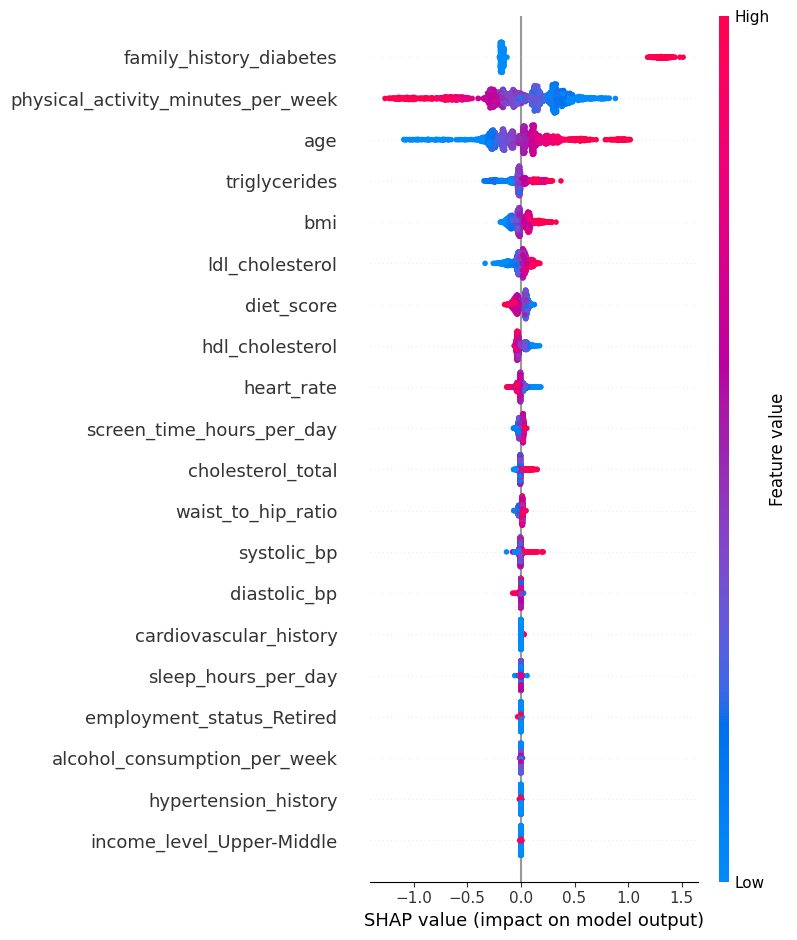

In [10]:
train_df = pd.read_csv('../data/train.csv')
explain_model_with_shap(train_df, '../model/my_xgboost.pkl')


## model with numeric features


--- Starting SHAP Analysis using model: ../model/xgb_numeric_only.pkl ---
Transforming data for SHAP...
Data is large, sampling first 2000 rows for SHAP analysis...
Generating SHAP Summary Plot...


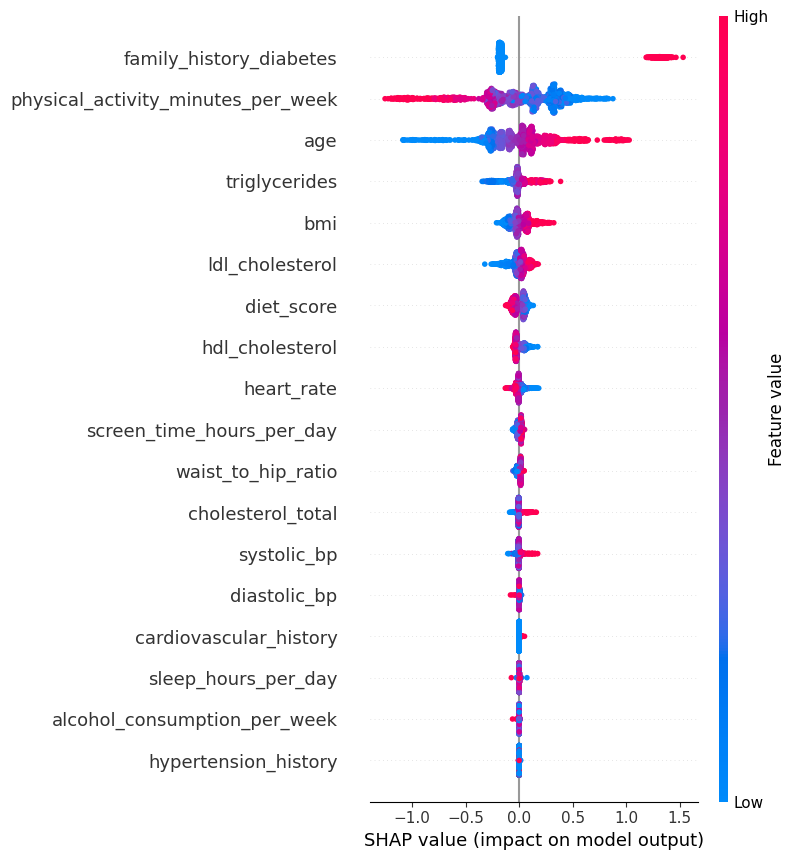

In [12]:
train_df = pd.read_csv('../data/train.csv')
explain_model_with_shap(train_df, '../model/xgb_numeric_only.pkl')
